In [1]:
# Данные тут
# https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

#pip install tscv
import tscv

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

## Добавим время в абсалютном варианте


In [2]:
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',
                 index_col='Date',
                 parse_dates = True, date_format='mixed').sort_index()
df = df[~df.index.duplicated(keep='last')]
df = df.dropna()
df = df.drop(['Fremont Bridge East Sidewalk','Fremont Bridge West Sidewalk'],axis=1)

data = df.resample('60min').asfreq().interpolate(method='piecewise_polynomial').astype('int')

data.columns = ['Total']
data.head()

,Total
Date,
2012-10-03 00:00:00,13
2012-10-03 01:00:00,10
2012-10-03 02:00:00,2
2012-10-03 03:00:00,5
2012-10-03 04:00:00,7


In [3]:
data_tscv = data['2019-07':'2019-09']

gap_size = 3*24

cv = tscv.GapKFold( n_splits=5, gap_before= 3*23, gap_after=3*23)

X_train, X_test, y_train, y_test = tscv.gap_train_test_split(
                data_tscv.index.to_pydatetime().reshape(-1,1), 
                data_tscv['Total'], 
                test_size = 0.25, 
                gap_size=gap_size)
data_tscv.head(5)

,Total
Date,
2019-07-01 00:00:00,10
2019-07-01 01:00:00,6
2019-07-01 02:00:00,3
2019-07-01 03:00:00,2
2019-07-01 04:00:00,12


In [4]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    r2 = cv_results["test_r2"]
    print(
        f"Mean Absolute Error (MAE):     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
        f"R^2 : {r2.mean():.3f} +/- {r2.std():.3f}"
    )

In [5]:
def transform_time_hour(X):
    """Конвектор datetime  в числовой формат"""
    return pd.DataFrame(X).apply(lambda x: pd.DatetimeIndex(x).hour)

def transform_time(tmp='hour'):
    """Универсальеый конвектор datetime  в числовой формат"""
    """код пишет сам себя :)"""
    return eval('FunctionTransformer(lambda X: pd.DataFrame(X).apply(lambda x: \
                pd.DatetimeIndex(x).'+tmp+'))')


In [6]:
transform_time_hour(X_train).head(3)

,0
0,0
1,1
2,2


In [7]:
ct = ColumnTransformer(
    [
     ("hour",  transform_time('hour'),[0]),
     ("day",   transform_time('day'),[0]),
     ("week",  transform_time('weekday'),[0]),
     ("month", transform_time('month'),[0])
    ])
ct.fit_transform(X_train)[:5]

array([[0, 1, 0, 7],
       [1, 1, 0, 7],
       [2, 1, 0, 7],
       [3, 1, 0, 7],
       [4, 1, 0, 7]], dtype=int32)

Mean Absolute Error (MAE):     40.268 +/- 6.618
Root Mean Squared Error (RMSE): 75.101 +/- 14.714
R^2 : 0.853 +/- 0.086


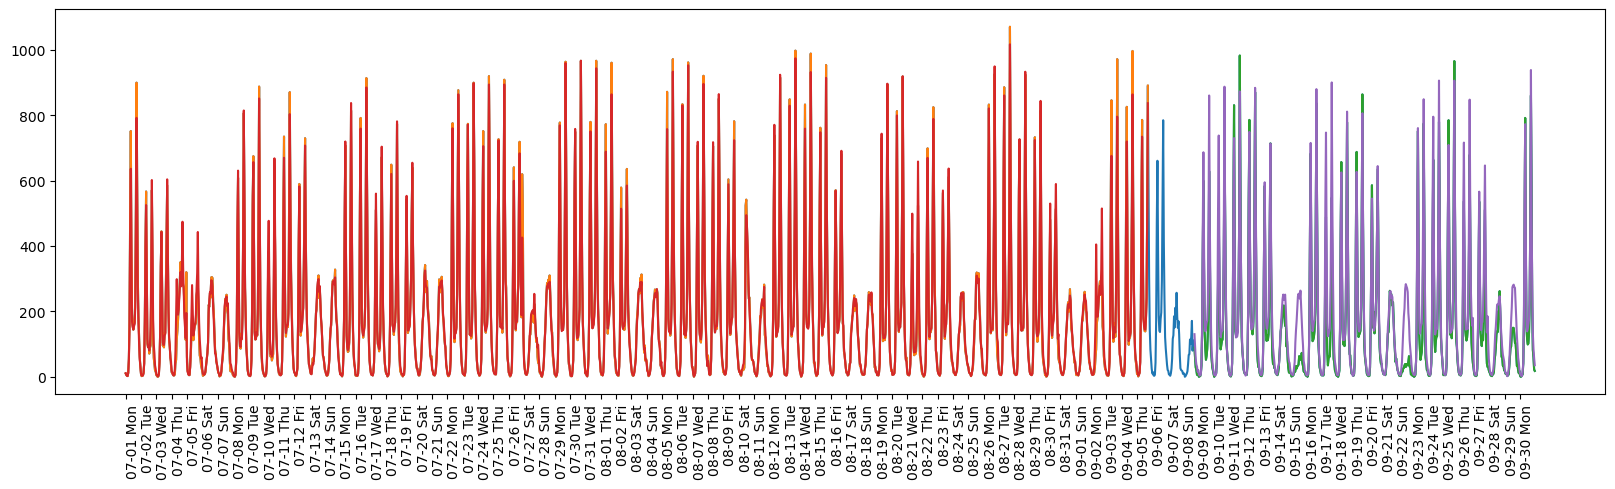

In [11]:
ct = ColumnTransformer(
    [
     ("hour",  transform_time('hour'),[0]),
     ("day",   transform_time('day'),[0]),
     ("week",  transform_time('weekday'),[0]),
     ("month", transform_time('month'),[0])
    ])

pipe_1 = make_pipeline(ct, RandomForestRegressor(n_estimators=100))
pipe_1.fit(X_train, y_train)

evaluate(pipe_1, X_train, y_train, cv)

pipe_1.fit(X_train, y_train)
y_train_predict = pipe_1.predict(X_train)
y_predict = pipe_1.predict(X_test)


plt.figure(figsize=(20, 5))

### исходные данные

xticks = pd.date_range(start = data_tscv.index.min(), end=data_tscv.index.max(),freq='D')
x_range = [data_tscv.index.get_loc(t) for t in xticks]

plt.xticks(x_range, xticks.strftime("%m-%d %a"), rotation=90, ha="left")

# все истина
plt.plot(range(len(data_tscv)), data_tscv.values.reshape(-1,1), label="all")
# тренировка истина
plt.plot(range(len(X_train)), y_train, label="train")
# тест истина
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_test, label="train");

# тренировка predict
plt.plot(range(len(X_train)), y_train_predict, label="train predict")

# тренировка predict
plt.plot(range(len(X_train)+gap_size,len(X_train)+gap_size+len(X_test)), y_predict, label="predict");